In [1]:
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [2]:
indicators = ['T10Y2Y','DGS10','INDPRO']
df_bruto = pdr.get_data_fred(indicators,start='1998-01-01').resample('MS').last().dropna()
df_prices = yf.download(['^SPX','^DJR'],start='1998-01-01')['Adj Close']
df_stocks = df_prices.pct_change().dropna().add(1).cumprod().sub(1)*100
df_base = pd.merge(left=df_prices.resample('MS').last().dropna(), right=df_bruto, how='inner', left_index=True, right_index=True)
df_base[['INDPRO','^SPX','^DJR']] = df_base[['INDPRO','^SPX','^DJR']].pct_change()
df_base.dropna(inplace=True)

[*********************100%%**********************]  2 of 2 completed


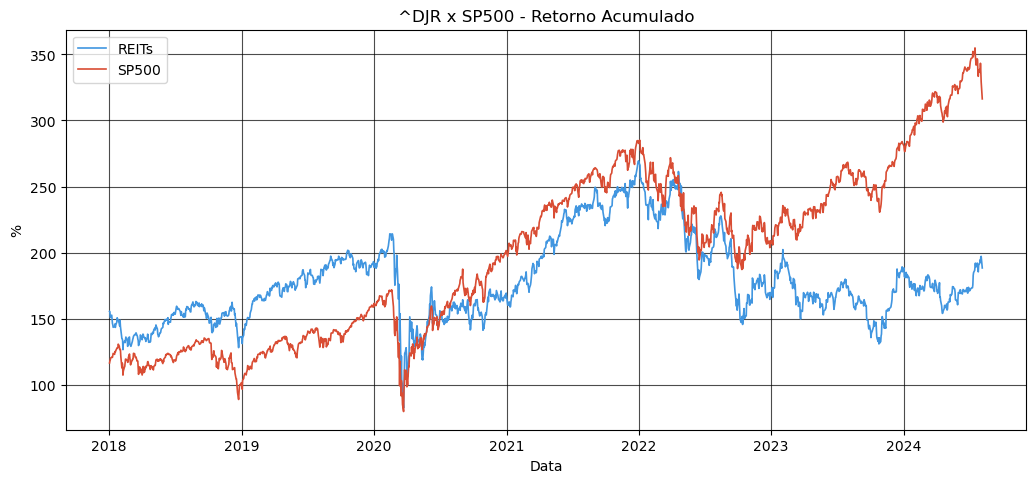

In [3]:
plt.figure(figsize=(12, 5))

plt.plot(df_stocks[df_stocks.index.year >= 2018].index, df_stocks[df_stocks.index.year >= 2018]['^DJR'], label='REITs', color='#4196e0',linewidth=1.2)
plt.plot(df_stocks[df_stocks.index.year >= 2018].index, df_stocks[df_stocks.index.year >= 2018]['^SPX'], label='SP500', color='#d94d34',linewidth=1.2)

plt.title('^DJR x SP500 - Retorno Acumulado')
plt.xlabel('Data')
plt.ylabel('%')
plt.legend()

plt.grid(True, linestyle='-', color='black', alpha=0.7)


plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.savefig('REITSxSP500.png')
plt.show()


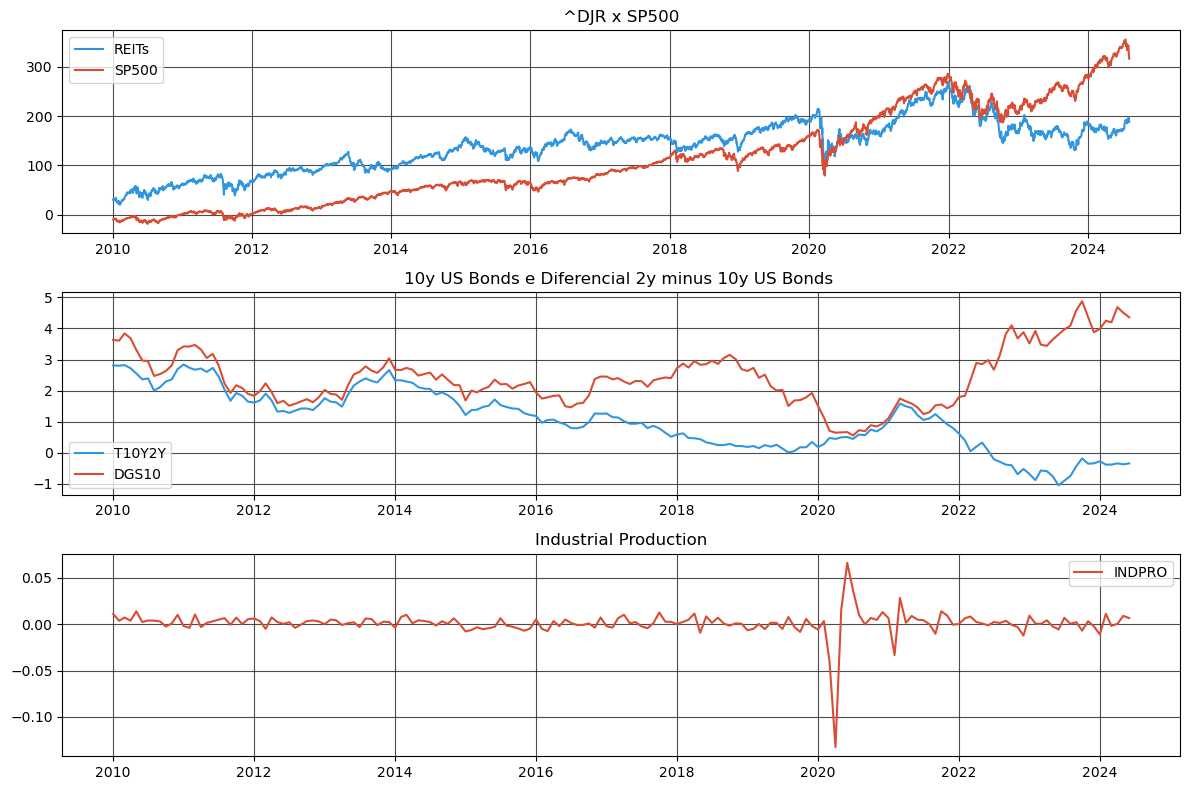

In [4]:
plt.subplots(3,1,figsize=(12, 8))
plt.subplot(311)
plt.plot(df_stocks[df_stocks.index.year >=2010].index, df_stocks[df_stocks.index.year >=2010]['^DJR'], label='REITs', color='#3196e0')
plt.plot(df_stocks[df_stocks.index.year >=2010].index, df_stocks[df_stocks.index.year >=2010]['^SPX'], label='SP500', color='#d94d34')
plt.grid(True, linestyle='-', color='black', alpha=0.7)
plt.legend()
plt.title('^DJR x SP500')

plt.subplot(312)
plt.plot(df_base[df_base.index.year >=2010].index, df_base[df_base.index.year >=2010]['T10Y2Y'], label='T10Y2Y', color='#3196e0')
plt.plot(df_base[df_base.index.year >=2010].index, df_base[df_base.index.year >=2010]['DGS10'], label='DGS10', color='#d94d34')
plt.grid(True, linestyle='-', color='black', alpha=0.7)
plt.legend()
plt.title('10y US Bonds e Diferencial 2y minus 10y US Bonds ')

plt.subplot(313)
plt.plot(df_base[df_base.index.year >=2010].index, df_base[df_base.index.year >=2010]['INDPRO'], label='INDPRO', color='#d94d34')
plt.grid(True, linestyle='-', color='black', alpha=0.7)
plt.legend()
plt.title('Industrial Production')



plt.subplots_adjust(hspace=0.45)
plt.tight_layout() 
plt.savefig('REITSxYcurve.png')
plt.show()



# Verificação de estacionariedade nas séries e tratamento

In [5]:
from statsmodels.tsa.stattools import adfuller
adf_results = [adfuller(df_base[column]) for column in df_base.columns]
adf_results_df = pd.DataFrame(adf_results, columns=['ADF Statistic', 'p-value', 'usedlag', 'nobs', 'critical values', 'icbest'], index=df_base.columns)
print("\nTeste de Dickey-Fuller aumentado:\n")
adf_results_df[['ADF Statistic', 'p-value']]


Teste de Dickey-Fuller aumentado:



,ADF Statistic,p-value
^DJR,-7.190082,2.516964e-10
^SPX,-12.203293,1.209419e-22
T10Y2Y,-1.495122,5.359230e-01
DGS10,-1.915716,3.247042e-01
INDPRO,-12.802679,6.701961e-24


Sendo as séries DGS10 e T10Y2Y são não estacionarias, aplicou-se uma diferenciação de ordem 1 

In [6]:
df_base = df_base.diff(periods=12).dropna()
adf_results_diff = [adfuller(df_base[column]) for column in df_base.columns]
adf_results_diff_df = pd.DataFrame(adf_results_diff, columns=['ADF Statistic', 'p-value', 'usedlag', 'nobs', 'critical values', 'icbest'], index=df_base.columns)
print("\nTeste de Dickey-Fuller aumentado:\n")
adf_results_diff_df[['ADF Statistic', 'p-value']].style.format('{:.5f}')


Teste de Dickey-Fuller aumentado:



,ADF Statistic,p-value
^DJR,-4.20696,0.00064
^SPX,-7.72478,0.00000
T10Y2Y,-3.38981,0.01131
DGS10,-3.18550,0.02084
INDPRO,-6.14075,0.00000


# Construção do Modelo
Construção do modelo VAR com 3 lags

In [7]:
from statsmodels.tsa.api import VAR
Y = df_base['^DJR']
X = df_base.drop(columns='^DJR')

data_VAR = pd.concat([Y, X], axis=1)

model_VAR = VAR(data_VAR)
results = model_VAR.fit(maxlags=3, ic='aic')  
resids_var = results.resid
print(results.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 06, Aug, 2024
Time:                     03:08:22
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -24.4176
Nobs:                     263.000    HQIC:                  -24.8644
Log likelihood:           1498.25    FPE:                1.17824e-11
AIC:                     -25.1647    Det(Omega_mle):     9.59972e-12
--------------------------------------------------------------------
Results for equation ^DJR
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000002         0.005128            0.000           1.000
L1.^DJR          -0.194259         0.092945           -2.090           0.037
L1.^SPX           0.288379         0.128853            2.238           0.025


Verificando autocorrelação dos resíduos do modelo VAR

In [8]:
ljung_box_results = pd.DataFrame()
for column in resids_var.columns:
    ljung_box_results[column] = sm.stats.acorr_ljungbox(resids_var[column], lags=[10], return_df=True).T
print("\nTeste de Ljung-Box:\n")
ljung_box_results.style.format('{:.5f}')


Teste de Ljung-Box:



,^DJR,^SPX,T10Y2Y,DGS10,INDPRO
lb_stat,4.12430,9.80059,12.85624,11.42218,10.50484
lb_pvalue,0.94157,0.45816,0.23182,0.32559,0.39737


Verificação da estacionariedade das séries

In [9]:
from statsmodels.tsa.stattools import adfuller
adf_results = [adfuller(data_VAR[column]) for column in data_VAR.columns]
adf_results_df = pd.DataFrame(adf_results, columns=['ADF Statistic', 'p-value', 'usedlag', 'nobs', 'critical values', 'icbest'], index=data_VAR.columns)
print("\nTeste de Dickey-Fuller aumentado:\n")
adf_results_df[['ADF Statistic', 'p-value']].style.format('{:.5f}')


Teste de Dickey-Fuller aumentado:



,ADF Statistic,p-value
^DJR,-4.20696,0.00064
^SPX,-7.72478,0.00000
T10Y2Y,-3.38981,0.01131
DGS10,-3.18550,0.02084
INDPRO,-6.14075,0.00000


Verificação de estabilidade do modelo VAR

In [10]:

stability_check = results.is_stable()
print("\nModelo estável:",stability_check)


Modelo estável: True


Verificação de causalidade entre as variáveis

In [11]:
granger_test = results.test_causality('^DJR', ['T10Y2Y','DGS10','INDPRO','^SPX'], kind='f',signif=0.1)
print("\nTeste de Causalidade de Granger:\n", granger_test.summary())



Teste de Causalidade de Granger:
 Granger causality F-test. H_0: ['T10Y2Y', 'DGS10', 'INDPRO', '^SPX'] do not Granger-cause ^DJR. Conclusion: reject H_0 at 10% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.795          1.675   0.074 (8, 1260)
-----------------------------------------------


In [12]:
coefficients = results.params
coefficients_df = pd.DataFrame(coefficients)
print("Coeficientes do Modelo VAR:\n")
coefficients_df


Coeficientes do Modelo VAR:



,^DJR,^SPX,T10Y2Y,DGS10,INDPRO
const,0.000002,0.001237,-0.010485,-0.006810,0.000064
L1.^DJR,-0.194259,0.030420,0.555445,1.244382,0.032606
L1.^SPX,0.288379,-0.004393,-0.270771,-0.010840,0.043603
L1.T10Y2Y,-0.018334,0.023491,1.190593,-0.079812,-0.008555
L1.DGS10,-0.009769,-0.014319,-0.069368,1.060532,0.010568
L1.INDPRO,0.163393,-0.092049,-2.557946,-1.604909,0.235590
L2.^DJR,-0.075113,-0.062018,-0.402096,-0.362041,0.002051
L2.^SPX,0.107013,0.110810,1.230182,0.698412,0.045825
L2.T10Y2Y,0.025220,-0.025650,-0.262826,0.021595,0.010312
L2.DGS10,0.011049,0.005107,0.031448,-0.163718,-0.008128


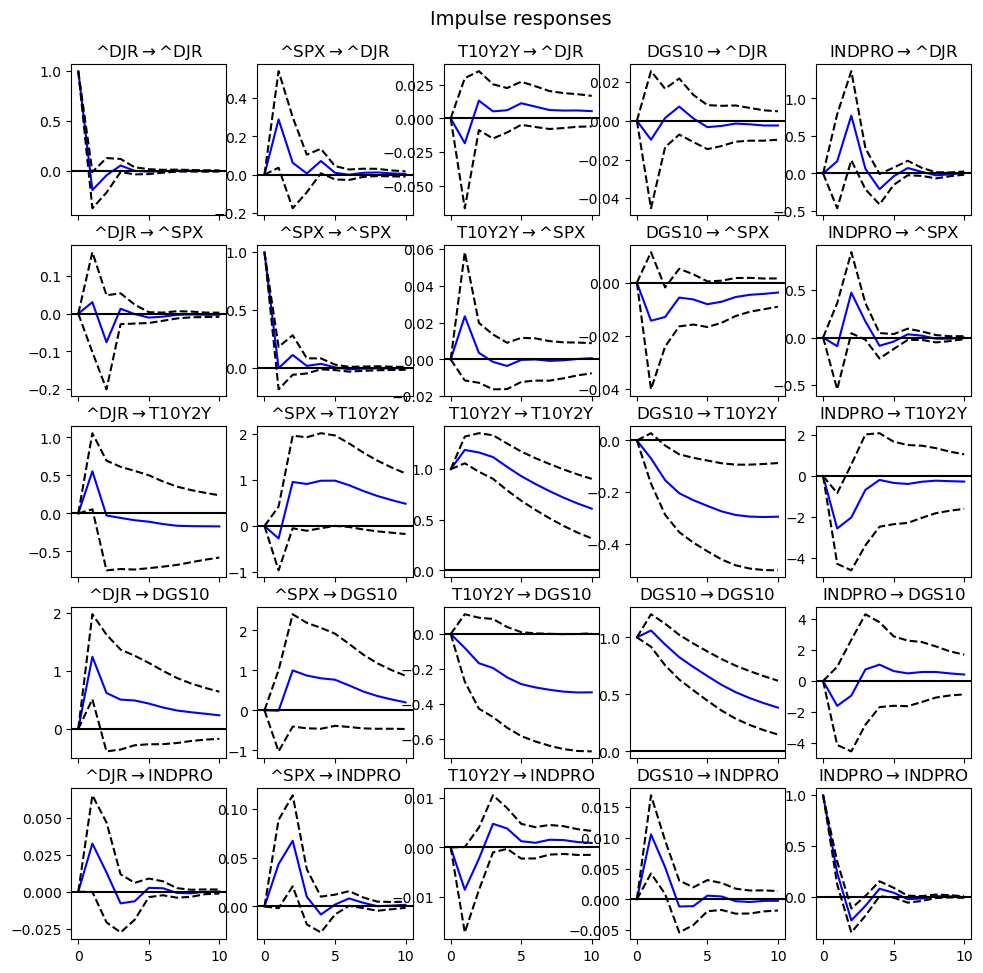

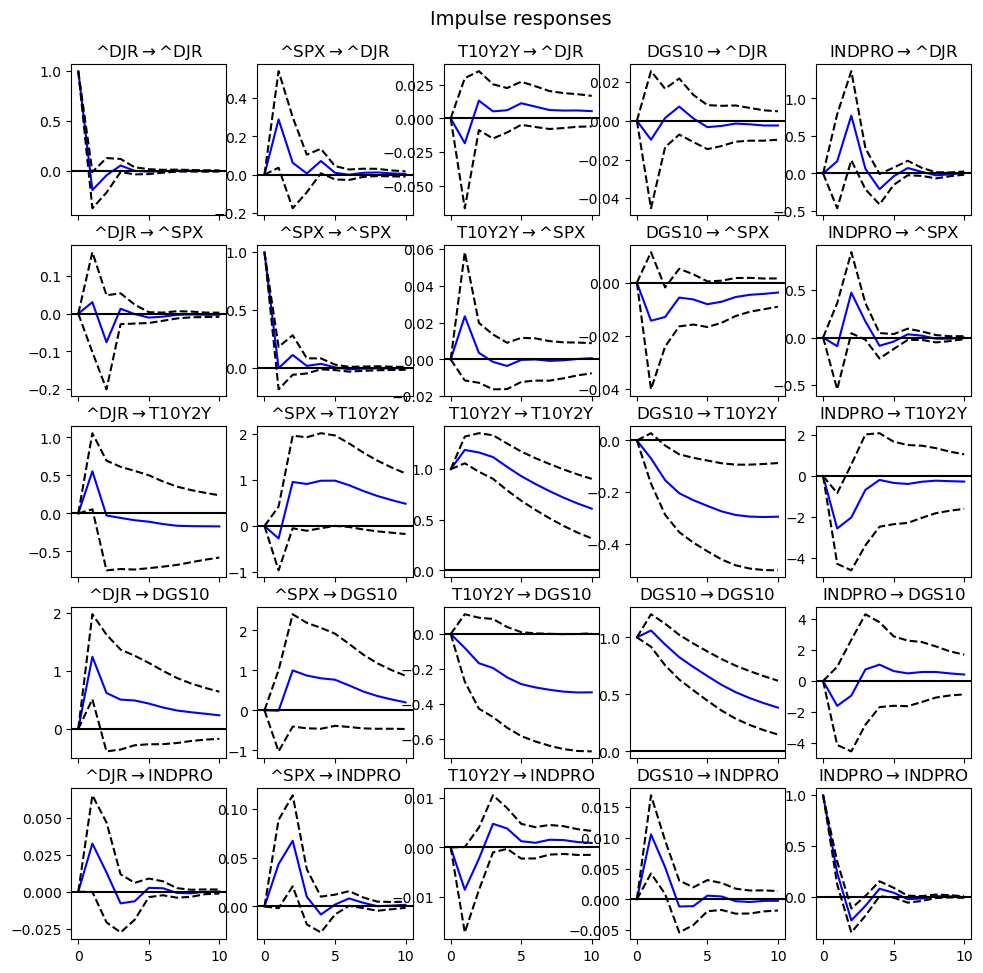

In [13]:
irf = results.irf(10) 
irf.plot()